# Test Sentiment Classification
### On Amazon-Review, Full Heterogeneous Graph

In [1]:
import numpy as np
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule
import time
import torch

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 256

In [3]:
# tag_dep_seq_sent = TextGraphType.TAGS | TextGraphType.DEPENDENCY | TextGraphType.SEQUENTIAL | TextGraphType.SENTENCE | TextGraphType.SENTIMENT
tag_dep_seq_sent = TextGraphType.SENTIMENT
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=False, start_data_load=0 , end_data_load = -1, device='cpu', batch_size=batch_size, graph_type=tag_dep_seq_sent, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AmazonReview\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 110/110 [21:06<00:00, 11.52s/it]

self.shuffle: False


In [8]:
# data_manager.update_batch_size(128)
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))
# X1.metadata()
len(X1)

256

In [9]:
from Scripts.Models.LightningModels.LightningModels import HeteroBinaryLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import HeteroLossArgs, HeteroLoss1, HeteroLoss2
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [10]:
X1.metadata()

(['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [11]:
edge_type_weights = {
    'full': [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    'seq': [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    'dep': [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    'tag': [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    'general_sentence': [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
    'sentence': [0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
    'sentiment': [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
}

In [12]:
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding2 import HeteroDeepGraphEmbedding2

In [25]:
import torch
from Scripts.Models.LightningModels.LightningModels import BaseLightningModel
from Scripts.Models.ModelsManager.ModelManager import ModelManager
import pandas as pd
import matplotlib.pyplot as plt
from typing import List
from torch_geometric.nn import summary
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from os import path

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss

class ClassifierModelManager(ModelManager):

    def __init__(self,
                 torch_model: torch.nn.Module,
                 lightning_model: BaseLightningModel,
                 model_save_dir: str = '~/Desktop',
                 log_dir: str = 'logs/',
                 log_name: str = 'model_logs',
                 device='cpu',
                 num_train_epoch = 100):
        super(ClassifierModelManager, self).__init__(torch_model, lightning_model, model_save_dir, log_dir, log_name, device, num_train_epoch)

    def _create_callbacks(self) -> List[Callback]:
        return [
            ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
            # EarlyStopping(patience=50, mode='max', monitor='val_acc')
        ]

    def draw_summary(self, dataloader):
        X, y = next(iter(dataloader))
        print(summary(self.torch_model, X.to(self.device)))

    def plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        plt.show()

    def save_plot_csv_logger(self, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc'], name_prepend: str=""):
        csv_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', 'metrics.csv')
        metrics = pd.read_csv(csv_path)

        aggregation_metrics = []
        agg_col = 'epoch'
        for i, dfg in metrics.groupby(agg_col):
            agg = dict(dfg.mean())
            agg[agg_col] = i
            aggregation_metrics.append(agg)

        df_metrics = pd.DataFrame(aggregation_metrics)
        df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
        
        loss_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_loss_metric.png')
        plt.savefig(loss_png)
        
        df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
        
        acc_png = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_acc_metric.png')
        plt.savefig(acc_png)
        
        plt.close()
    
    def evaluate(self, eval_dataloader,
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.torch_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        if(give_confusion_matrix):
            print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}')
        if(give_report):
            print(classification_report(y_true, y_pred))
        if(give_f1_score):
            print(f'f1_score: {f1_score(y_true, y_pred)}')
        if(give_accuracy_score):
            print(f'accuracy_score: {accuracy_score(y_true, y_pred)}')
        if(give_precision_score):
            print(f'precision_score: {precision_score(y_true, y_pred)}')
        if(give_recall_score):
            print(f'recall_score: {recall_score(y_true, y_pred)}')
        if(give_hinge_loss):
            print(f'hinge_loss: {hinge_loss(y_true, y_pred)}')
                
    def save_evaluation(self, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False):
        
        test_metrics_path = path.join(self.log_dir, self.log_name, f'version_{self.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        self.lightning_model.eval()
        for X, y in eval_dataloader:
            y_p = self.torch_model(X.to(self.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
            y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true, y_pred)}', file=f)
            if(give_report):
                print(classification_report(y_true, y_pred), file=f)
            if(give_f1_score):
                print(f'f1_score: {f1_score(y_true, y_pred)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true, y_pred)}', file=f)
            if(give_precision_score):
                print(f'precision_score: {precision_score(y_true, y_pred)}', file=f)
            if(give_recall_score):
                print(f'recall_score: {recall_score(y_true, y_pred)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true, y_pred)}', file=f)

In [27]:
for k in edge_type_weights:
    graph_embedding = HeteroDeepGraphEmbedding2(300, 1, X1.metadata(), 128, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights[k])
    graph_embedding = graph_embedding.to(device)
    callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]
    lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                    torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.001),
                                        loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.005),
                                        learning_rate=0.0045,
                                        batch_size=batch_size,
                                        user_lr_scheduler=True,
                                        min_lr=0.0003
                                        ).to(device)
    model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_7', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_7',device=device, num_train_epoch=70)
    model_manager.fit(datamodule=data_manager)
    model_manager.save_plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{k}')
    model_manager.torch_model = model_manager.torch_model.to('cuda')
    model_manager.save_evaluation(data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


bbbb


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding2 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
22        Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
X1, y1 = next(iter(data_manager.test_dataloader()))
X1.edge_attr_dict[('dep',  'dep_word',  'word')]

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [12]:

callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]
lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                 torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.001),
                                       loss_func=HeteroLoss1(exception_keys=['word'], enc_factor=0.005),
                                       learning_rate=0.0045,
                                       batch_size=batch_size,
                                       user_lr_scheduler=True,
                                       min_lr=0.0003
                                       ).to(device)

# lightning_model = HeteroBinaryLightningModel.load_from_checkpoint(r'logs\hetero_model_6\version_17\checkpoints\epoch=1-step=541.ckpt', model=graph_embedding)

# lightning_model.loss_func = HeteroLoss1(exception_keys=['word'], enc_factor=0)
# lightning_model.learning_rate = 0.0003
# lightning_model.optimizer = torch.optim.SGD(graph_embedding.parameters(), lr=0.0003, weight_decay=0.0001)
# lightning_model.batch_size = batch_size
# lightning_model.min_lr = 0.00003

model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_6', model_save_dir=r'C:\Users\fardin\Projects\ColorIntelligence\Practices\Tasks\HeterogeneousGraphs\hetero_model_3',device=device, num_train_epoch=150)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
model_manager.lightning_model.model.pw1

Parameter containing:
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
part_weight_norm = torch.nn.LayerNorm((11, )).to(device)
part_weight_norm(model_manager.lightning_model.model.pw2)

tensor([-0.3162, -0.3162, -0.3162, -0.3162,  3.1621, -0.3162, -0.3162, -0.3162,
        -0.3162, -0.3162, -0.3162], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)

In [41]:
parameters = dict(lightning_model.model.named_parameters())

In [21]:
X1.metadata()

(['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [22]:
# data_manager.shuffle = True
# data_manager.update_batch_size(256)

In [23]:
# lightning_model.loss_func = HeteroLoss1(exception_keys=['word'], enc_factor=0.01)
# lightning_model.learning_rate = 0.00015
# lightning_model.optimizer = torch.optim.SGD(graph_embedding.parameters(), lr=0.00015)
# lightning_model.batch_size = batch_size
# lightning_model.min_lr = 0.00001

In [52]:
parameters  =dict(model_manager.lightning_model.model.named_parameters())

In [13]:
# print(parameters)

In [27]:
model_manager.lightning_model.model.pw1[0] += 1
model_manager.lightning_model.model.pw1[1] += 1
model_manager.lightning_model.model.pw2[0] += 1
model_manager.lightning_model.model.pw2[1] += 1
print(model_manager.lightning_model.model.pw1)
print(model_manager.lightning_model.model.pw2)

Parameter containing:
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
Parameter containing:
tensor([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [ ]:
model_manager.trainer.fit_loop.max_epochs=1000
# model_manager.trainer.fit_loop.max_steps=-1

In [48]:
model_manager.lightning_model.loss_func.enc_factor = 0.1

In [14]:
# lr = 0.0045
# model_manager.update_learning_rate(0.004)
model_manager.fit(datamodule=data_manager)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding2 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
22        Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:293:

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [146]:
model_manager.lightning_model.update_learning_rate(0.0003)
model_manager.lightning_model.loss_func.enc_factor = 0.0

In [147]:
# lr = 0.001
model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_6\version_23\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding2 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
22        Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which m

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [12]:
model_manager.lightning_model.optimizer = torch.optim.SGD(graph_embedding.parameters(), lr=0.0003)
model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_6\version_18\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding1 | 2.2 M 
1 | loss_func | HeteroLoss1               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.829     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [30]:
model_manager.draw_summary(t_dataloader)

+------------------------------------------------------------+-----------------------------------+------------------------------+-----------+
| Layer                                                      | Input Shape                       | Output Shape                 | #Param    |
|------------------------------------------------------------+-----------------------------------+------------------------------+-----------|
| HeteroDeepGraphEmbedding1                                  | [51092, 51092]                    | [256, 1]                     | 2,207,246 |
| ├─(part_weight_norm)LayerNorm                              | [11]                              | [11]                         | 22        |
| ├─(norm)PairNorm                                           | --                                | --                           | --        |
| ├─(drop)Dropout                                            | --                                | --                           | --        |
| ├─(h

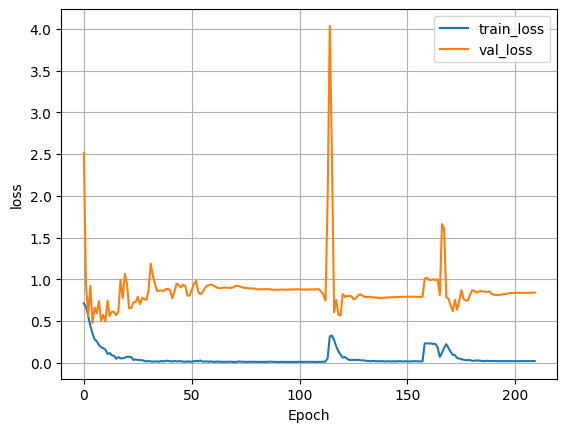

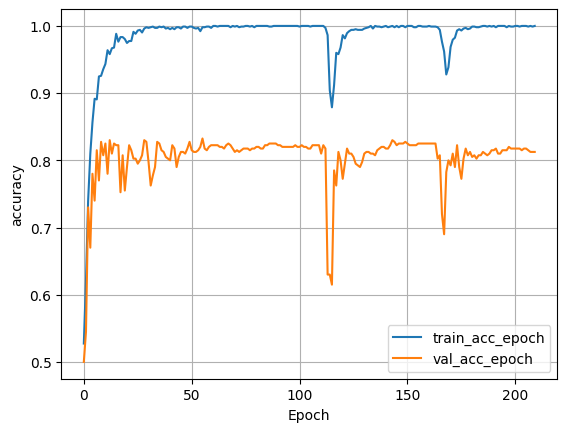

In [51]:
model_manager.plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'])

In [149]:
model_manager.torch_model = model_manager.torch_model.to('cuda')

In [15]:
model_manager.evaluate(data_manager.test_dataloader(), give_accuracy_score=True, give_hinge_loss=True)

confusion_matrix: 
[[172  32]
 [ 48 148]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       204
           1       0.82      0.76      0.79       196

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400

accuracy_score: 0.8
hinge_loss: 0.71


In [ ]:
model_manager.trainer.checkpoint_callback.best_model_path

'logs/hetero_model_6\\version_11\\checkpoints\\epoch=7-step=296.ckpt'

In [21]:
import pandas as pd

In [46]:
csv1 = pd.read_csv(r'logs\hetero_model_6\version_15\metrics.csv')
print(len(csv1.groupby('epoch')))
csv2 = pd.read_csv(r'logs\hetero_model_6\version_16\metrics.csv')
csv2['epoch'] += csv1['epoch'].max()
print(len(csv2.groupby('epoch')))
csv3 = pd.read_csv(r'logs\hetero_model_6\version_17\metrics.csv')
csv3['epoch'] += csv2['epoch'].max()
print(len(csv3.groupby('epoch')))
csv4 = pd.read_csv(r'logs\hetero_model_6\version_18\metrics.csv')
csv4['epoch'] += csv3['epoch'].max()
print(len(csv4.groupby('epoch')))

17
50
4
150


In [52]:
metrics_csv = pd.concat([csv1, csv2, csv3, csv4], ignore_index=True)
print(len(metrics_csv.groupby('epoch')))

218


In [53]:
import matplotlib.pyplot as plt
def plot_csv_logger(metrics, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch']):

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)

    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()

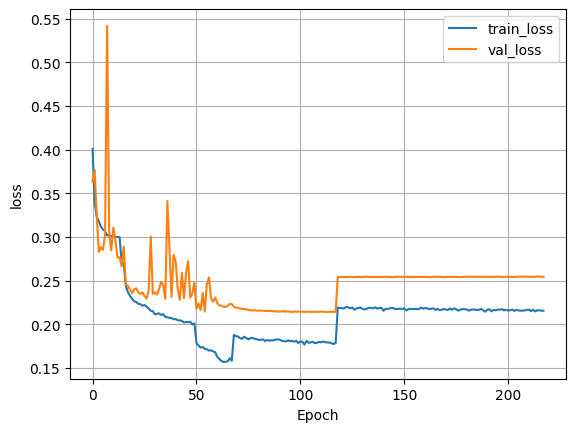

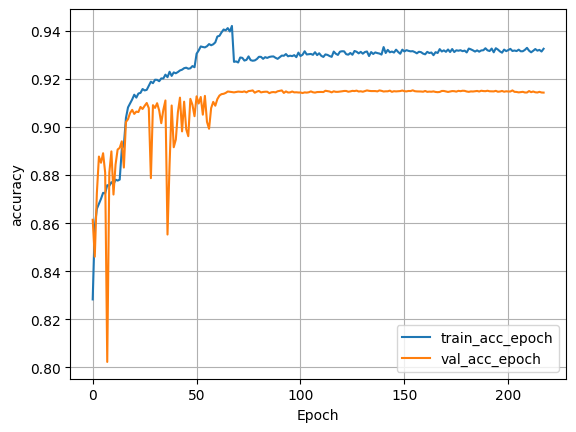

In [54]:
plot_csv_logger(metrics_csv)